# Notebook demo de sesion de registro en campo



In [1]:
import sounddevice as sd       
from acousticfield.session import RecordingSession
from acousticfield.io import play
from acousticfield.process import make_filterbank
from acousticfield.room import paracoustic
from acousticfield.display import *

# Ajuste de sounddevice
Elegir la interfaz de entrada salida si es necesario con sd.default_device[devicein,deviceout] usando los numeros que devuelve query_devices()

In [2]:
sd.query_devices()

> 0 Built-in Microphone, Core Audio (2 in, 0 out)
< 1 Built-in Output, Core Audio (0 in, 2 out)
  2 iShowU Audio Capture, Core Audio (2 in, 2 out)
  3 ZoomAudioDevice, Core Audio (2 in, 2 out)

In [3]:
#sd.default.device = [2,2]
fs = 48000

# Inicio de Sesion

Generacion de Metadata y nombres de archivo para los registros

In [9]:
parlantes = ["frente","atras","pasillo"]
mics = ["centro","publico1","publico2"]
tipo = "Ambi"
inchan = [0,1]
outchan = [0,1]
loopback = 1
s = RecordingSession("CETC1",parlantes,mics,inchan=inchan,outchan=outchan,loopback=loopback,
                     rtype=tipo,sampling_rate=fs,sweepfile="sweep_x1_48k_10s_30_22k")

In [10]:
ir1 = s.record_ir(3,2,take=1)

Recording ... CETC1_Spasillo_Mpublico1_2ch_loop_Ambi
finished
Extracting ---> CETC1_Spasillo_Mpublico1_2ch_loop_Ambi
DONE


In [11]:
s.list_recordings()

0:CETC1_Spasillo_Mpublico1_2ch_loop_Ambi


In [12]:
vars(s)

{'session_id': 'CETC1',
 'speakers': ['frente', 'atras', 'pasillo'],
 'microphones': ['centro', 'publico1', 'publico2'],
 'speaker_pos': [0, 0],
 'microphone_pos': [0, 0],
 'input_channels': [0, 1],
 'output_channels': [0, 1],
 'loopback': 1,
 'sampling_rate': 48000,
 'rtype': 'Ambi',
 'date': '2023-05-20',
 'hour': '02:25:51',
 'comments': '',
 'sweepfile': 'sweep_x1_48k_10s_30_22k',
 'rpath': '',
 'recordings': [['CETC1_Spasillo_Mpublico1_2ch_loop_Ambi', '']]}

In [13]:
ir1.shape

(285130, 1)

In [14]:
ir2 = s.load_ir(0)

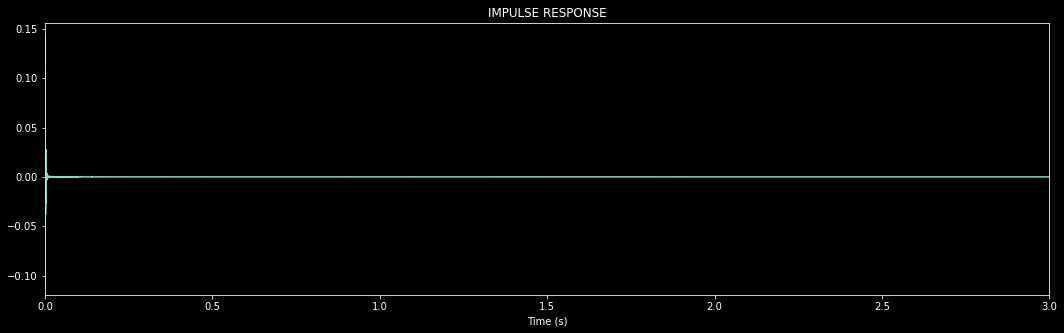

In [15]:
ir_plot(ir2,fs=fs)

In [16]:
play(ir1,chanout=[0,1],normalized=True,fs=fs)

In [17]:
ir1.shape

(285130, 1)

In [18]:
#echos = echo_display(ir1,0,fs=fs)

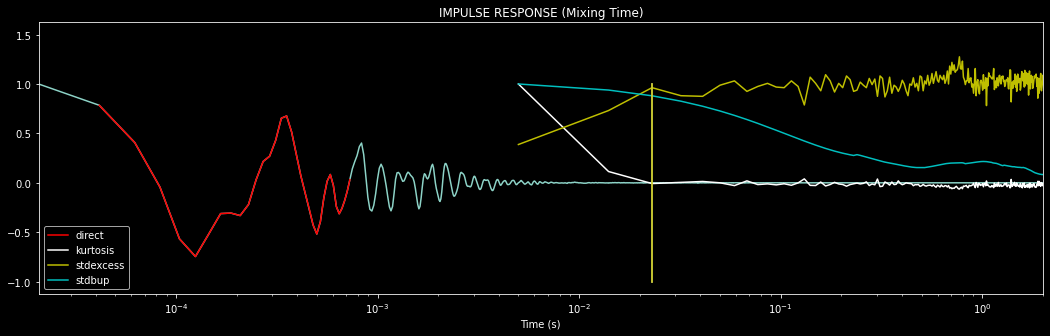

In [19]:
pstat = irstat_plot(ir1, window=0.01, overlap=0.001, logscale=True, fs=fs)

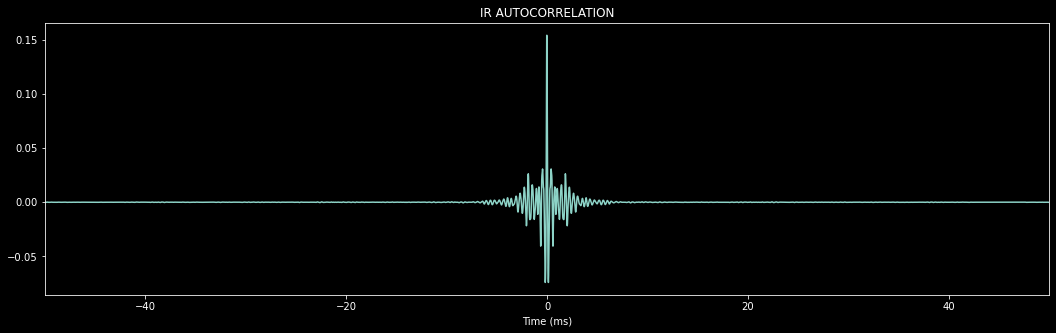

In [20]:
ac = acorr_plot(ir1,trange=0.05,fs=fs)

# Parametros acusticos

Calculo de los parametros acusticos usando paracoustic, el primer parametro es la RI (el array o el nombre de archivo), se puede especificarl el metodo para calcular el tiempo de reverberacion (rt30, rt20, rt15) y el banco de filtros a utilizar (el formato de nombre para el banco de filtros es fbank + frecuencia de sampleo + _ + numero de octavas + _ + numero de bandas por octavas. Por defecto el banco arranca en la octava de 62.5 para modificarlo se puede usar la funcion make_filterbank de process.

**paracoustic** devuelve un diccionario con todos los parametros por bandas, y dos columnas adicionales para ponderacion A y Flat. 

**pars_print** imprime todos los parametros (tambien se le puede pasar una lista de keys).

**pars_plot** hace graficos de los parametros que se le pasan como key.

Los parametros que se calculan son
- 'snr' relacion señal ruido en dB
- 'rt20' (o 'rt30' o 'rt15) tiempo de reverberacion en segundos
- 'edt' decaimiento temprano en segundos
- 'c50' y 'c80' claridad en dB con dos criterios
- 'ts' centro temporal en segundos
- 'dr' relacion directo reverberante en dB

Pero paracoustic tambien devuelve:
- 'rvalue' coeficiente de regresion del ajuste del decaimiento (puede incorporarse a parsprint)
- 'schr' integral de Schroeder para graficar el decaimiento
- 'lfit' 'tfit' intersecciones con tiempo y nivel donde realiza el ajuste de decaimiento

La funcion **parsdecay_plot** muestra los decaimientos por bandas en un multiplot.

En todos los casos muestra los datos de un solo canal (por defecto el canal 0 pero se puede especificar con el parametro chan)

In [18]:
#from acousticfield.process import make_filterbank
make_filterbank(fmin=62.5,noct=9,bwoct=1,fs=fs,bankname='fbank48k_9_1',show=True)

Banco de filtros generado: 9 octavas,1 bandas/octava,desde 62.5 Hz,Almacenada en archivo fbank48k_9_1


In [20]:
pars = paracoustic(ir1, method='rt20',bankname='fbank48k_9_1')

Using sample rate from filter bank:48000


In [22]:
pars_print(pars,chan=0)

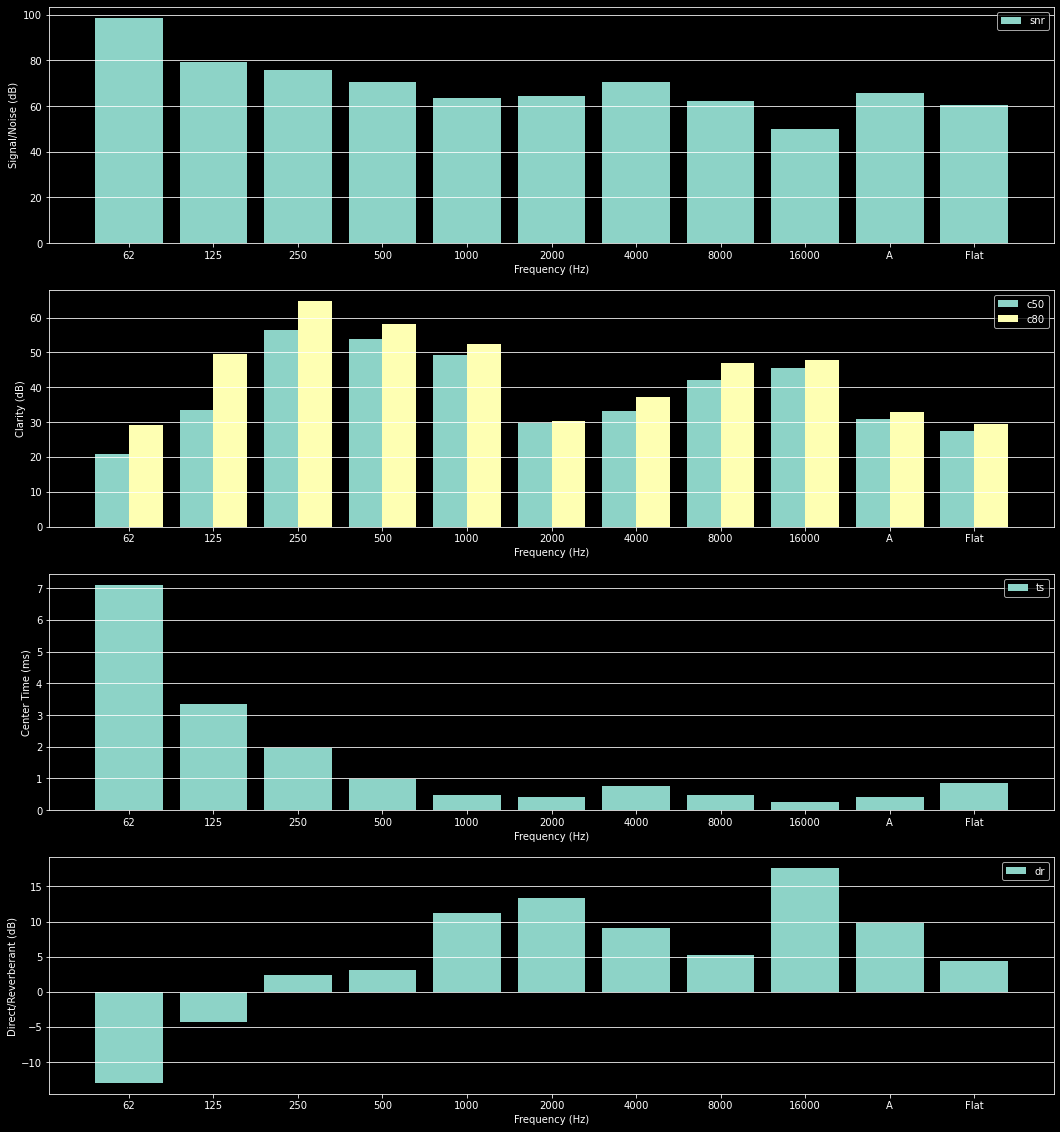

In [23]:
pars_plot(pars,['snr','rt30','c80','ts','dr'],chan=0)

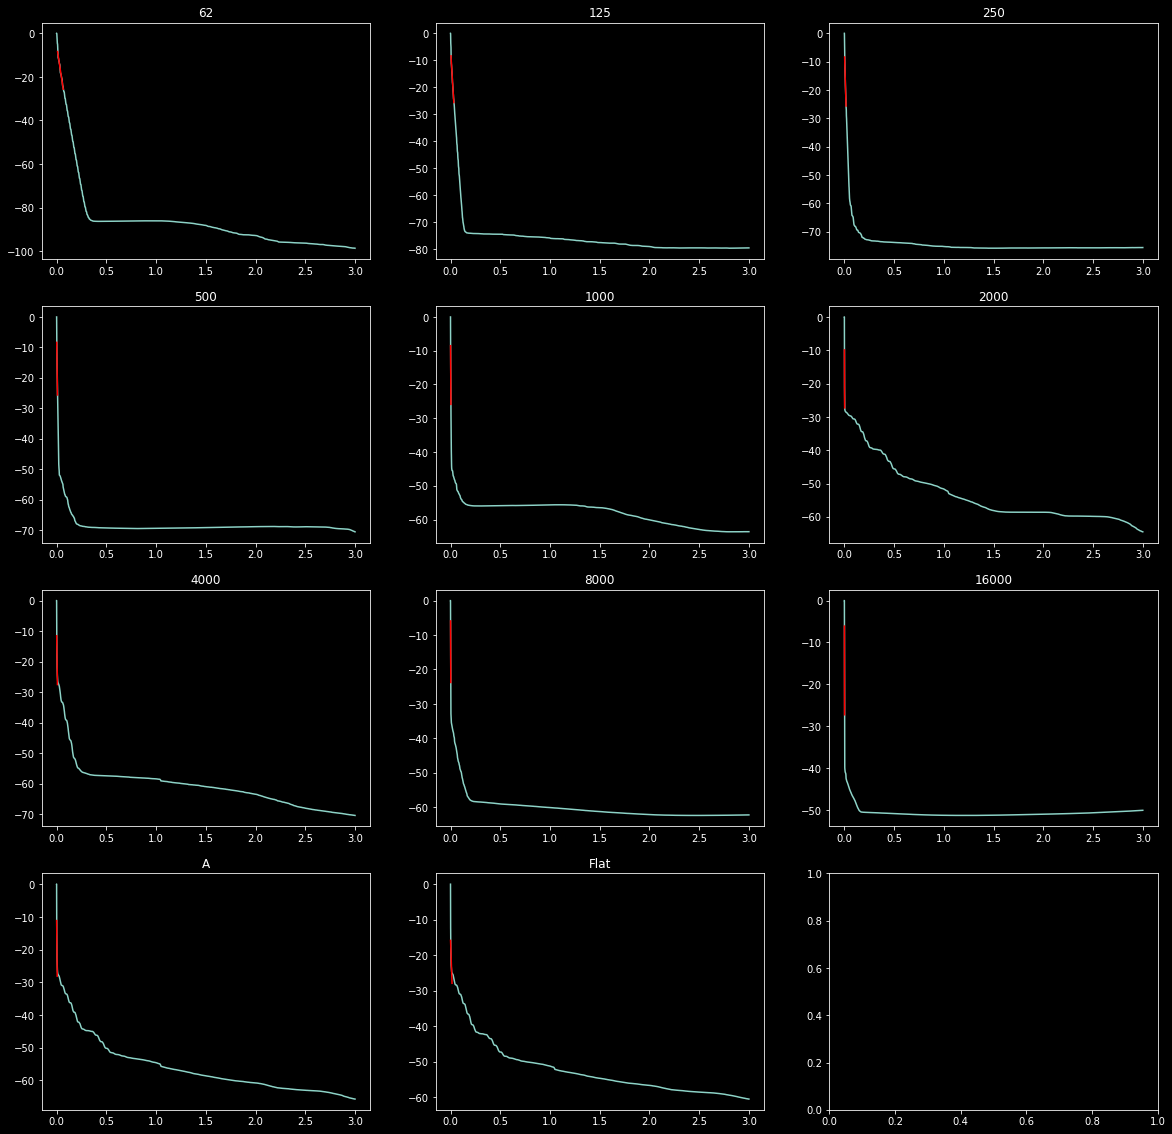

In [24]:
parsdecay_plot(pars,fs=fs)

# Funcion Transferencia

La funcion **spectrum_plot** grafica y devuelve el espectro (power spectral density) y la fft como amplitud y fase de una señal arbitraria (multicanal)

Si pasamos la respuesta impulso como señal recibimos la funcion de transferencia. El primer parametro puede ser un array o un nombre de archivo. Si es array hay que especificar la frecuencia de sampleo. logscale se refiere a la escala de frecuencias (la magnitud esta en dB). fmax es la frecuencia maxima que muestra en el grafico pero calcula todo hasta Nyquist. Devuelve un diccionario con keys 'f' 's' 'amplitude' 'phase' correspondientes a la lista de frecuencias, y arrays 2D (un canal por fila) con el espectro de potencias, la amplitud y la fase de la fft respectivamente.
bajo

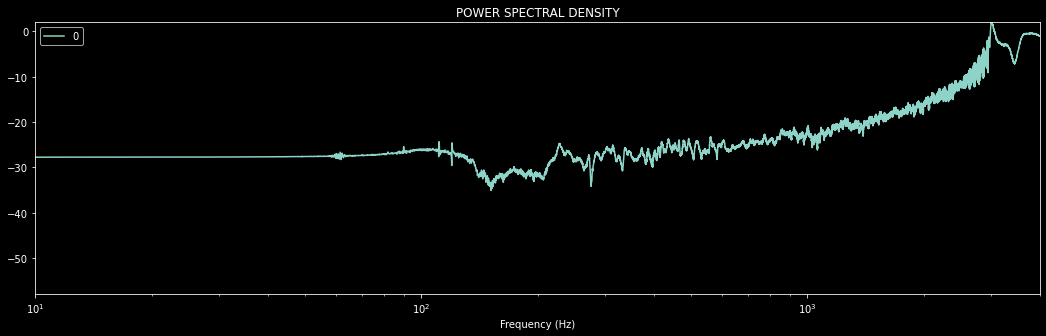

In [25]:
sp = spectrum_plot(ir1, logscale=True, fmax=4000, fs=fs)

# Espectrograma

Como en el caso anterior, **spectrogram_plot** grafica y devuelve el espectrograma (ahora de un solo canal que se puede especificar con el parametro chan). 
recibe como parametros ademas de la señal en primero lugar, el tamaño de ña ventana en samples 'window', el overlap de las ventanas en samples 'overlap' la frecuencia de sampleo y el rango en dB 'lrange'. 'normalize' = True normaliza la salida en amplitud.
Atencion, por ahora necesita el array (no el nombre de archivo)

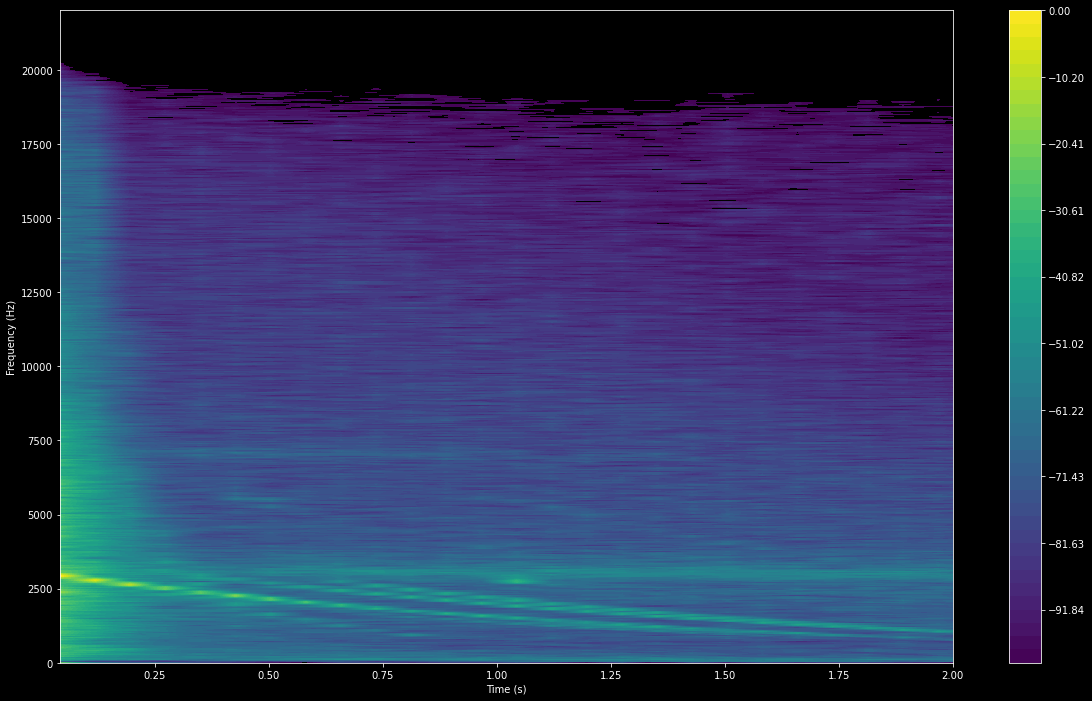

In [26]:
spec = spectrogram_plot(ir1,4096,400,chan=0,normalized=True,fs=fs,lrange=100,fmax=22000)